In [1]:
### IMPORTIERE PAKETE
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering, KMeans

from loadmodelingfunctions import generate_loadprofile, build_example_year, visualize_typedays, mape_simulation
import loaddata
import clustertools as ct
import dataprocessing as dp

### AUTORELOAD
%reload_ext autoreload
%autoreload 2

### LATEX-KOMPILIERUNG
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.size": '16'
})

Daten importieren

In [2]:
stationen=loaddata.load_stations()
display(stationen)
list_power_d, list_power_yd, list_power_ysd, list_power_ymd, list_mat_power_d, list_power_ywd, list_power_yswd, list_power_only_d = loaddata.load_data_from_measurements([0,1,2,3,4,5,6,7,8], d=True, yd=True, ysd=True,ywd=True,yswd=True)

,Name,Hausanschluesse,Leistung,Cluster,Kurzname,Zaehler,LeistungproHA,LeistungproZaehler,ZaehlerproHA
0,Durchholz,73,400,W4,A,99,5.479452,4.040404,1.356164
1,Guennemannshof,62,400,W1,B,72,6.451613,5.555556,1.161290
2,Kaemperfeld,24,630,W3,C,40,26.250000,15.750000,1.666667
3,Lutherplatz,53,630,S,D,394,11.886792,1.598985,7.433962
4,Marienhospital alt,43,630,S,E,382,14.651163,1.649215,8.883721
5,Querweg,26,400,W2,F,50,15.384615,8.000000,1.923077
6,Rehnocken 1,19,200,W2,G,34,10.526316,5.882353,1.789474
7,Rudolf-Koenig-Strasse,40,630,S,H,315,15.750000,2.000000,7.875000
8,Schule Durchholz,53,400,W1,I,90,7.547170,4.444444,1.698113


Lade Daten von Station  Durchholz
Lade Daten von Station  Guennemannshof
Lade Daten von Station  Kaemperfeld
Lade Daten von Station  Lutherplatz
Lade Daten von Station  Marienhospital alt
Lade Daten von Station  Querweg
Lade Daten von Station  Rehnocken 1
Lade Daten von Station  Rudolf-Koenig-Strasse
Lade Daten von Station  Schule Durchholz


Clusteranalyse

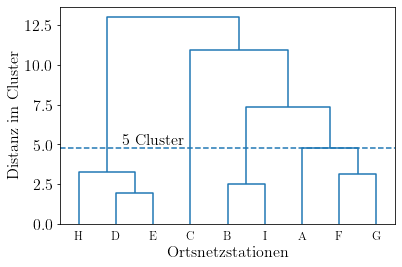

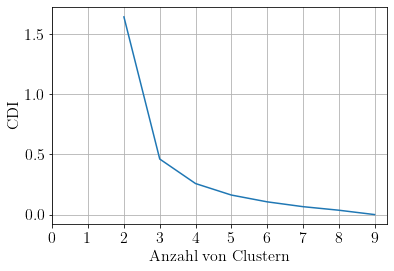

In [45]:
week_profiles = ct.build_winter_summer_week_profile(list_mat_power_d)
export_plots = True

### OPTIMALE ANZAHL

ct.analyze_cluster_indicators(week_profiles)
if export_plots:
    plt.savefig('export/DBI_CDI.pdf',bbox_inches='tight')

### HIERARCHISCHES CLUSTERN

n_clusters = 5
mymodel_opt = AgglomerativeClustering(n_clusters = n_clusters)
mymodel_opt = mymodel_opt.fit(week_profiles)

In [4]:
mymodel_opt.labels_

array([4, 3, 2, 0, 0, 1, 1, 0, 3], dtype=int64)

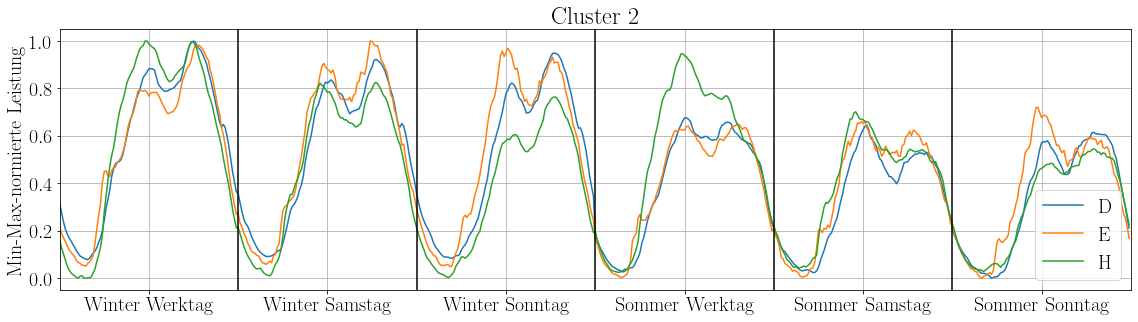

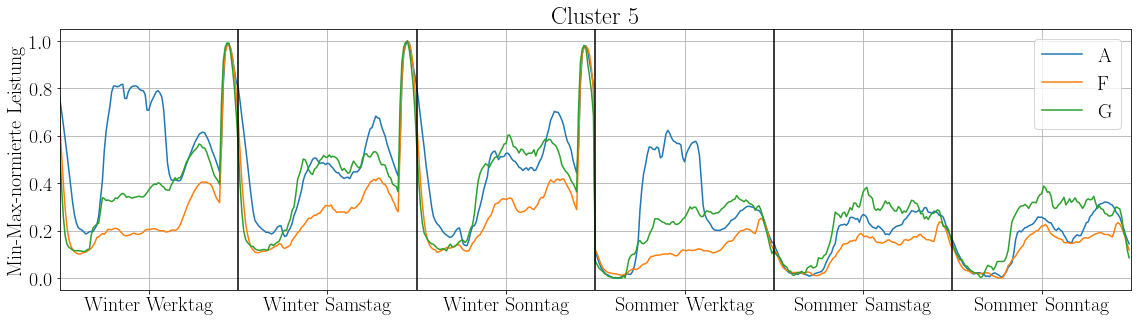

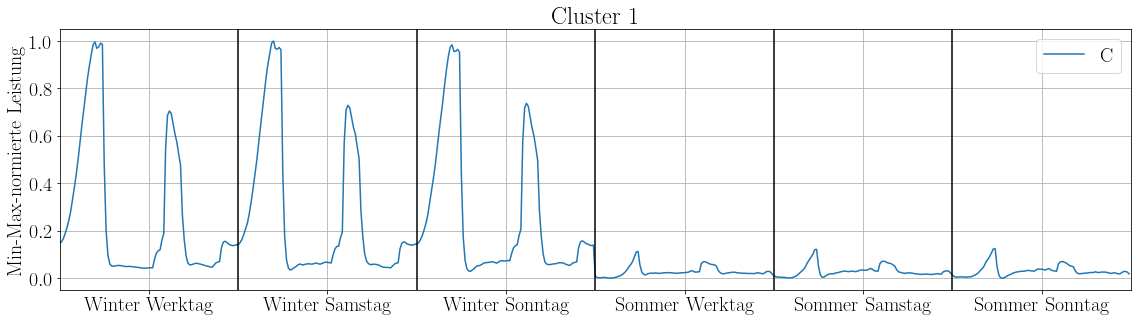

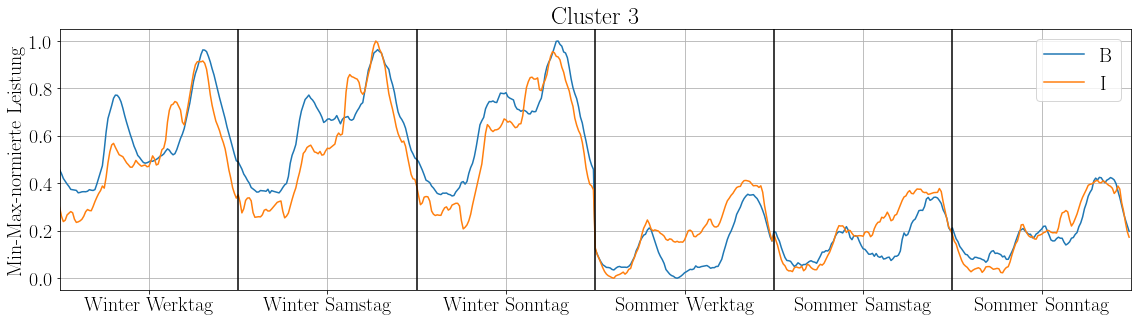

In [5]:

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.size": '20'
})
ct.plot_week_profiles_cluster(week_profiles,np.array([1, 3, 2, 0, 0, 1, 1, 0, 3]))

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.size": '16'
})

Lastprofile

In [6]:
cluster_names = ['SS','W1','W2','W3','W4']
anzahl_cluster = len(cluster_names)
label=mymodel_opt.labels_

###Generiere Cluster-Daten

all_powers_list = list()
all_powers_list_years = list()

for i in range(0,anzahl_cluster):
    ind=np.zeros(0,int)
    for j in range(0,9):
        if label[j]==i:
            ind=np.append(ind,j)
    list_power = list_power_ysd[ind[0]][2018]
    list_power_years = list_power_yd[ind[0]]
    for j in ind[1:len(ind)]:
        list_power = list_power + list_power_ysd[j][2018]
        list_power_years = list_power_years + list_power_yd[j]
    all_powers_list.insert(len(all_powers_list), list_power)
    all_powers_list_years.insert(len(all_powers_list_years), list_power_years)

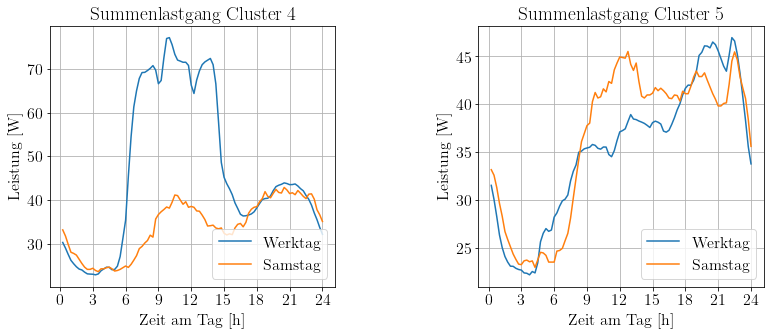

In [7]:
subfig, axs = plt.subplots(1,2,figsize=(12.8,4.8))

X=np.linspace(1,96,96)

nr = 0
A=all_powers_list[4].loc[:,2].loc[:,0].mean(axis=1).to_numpy()
B=all_powers_list[4].loc[:,2].loc[:,1].mean(axis=1).to_numpy()
axs[nr].plot(X,A)
axs[nr].plot(X,B)
axs[nr].set_xlabel('Zeit am Tag [h]')
axs[nr].set_xticks(np.arange(0,108, step=12),np.arange(0,25, step=3))
axs[nr].set_ylabel('Leistung [W]')
axs[nr].set_title('Summenlastgang Cluster 4')
axs[nr].legend(['Werktag','Samstag'],loc='lower right')
axs[nr].grid()

nr = 1
A=all_powers_list[1].loc[:,2].loc[:,0].mean(axis=1).to_numpy()
B=all_powers_list[1].loc[:,2].loc[:,1].mean(axis=1).to_numpy()
axs[nr].plot(X,A)
axs[nr].plot(X,B)
axs[nr].set_xlabel('Zeit am Tag [h]')
axs[nr].set_xticks(np.arange(0,108, step=12),np.arange(0,25, step=3))
axs[nr].set_ylabel('Leistung [W]')
axs[nr].set_title('Summenlastgang Cluster 5')
axs[nr].legend(['Werktag','Samstag'],loc='lower right')
axs[nr].grid()

plt.subplots_adjust(wspace=0.5)

plt.savefig('export/cluster_4_5_wochentag.pdf',bbox_inches='tight')

201.1178864865303
193.90144930963834
194.91994249354758
195.5214173343469
209.61123094577442


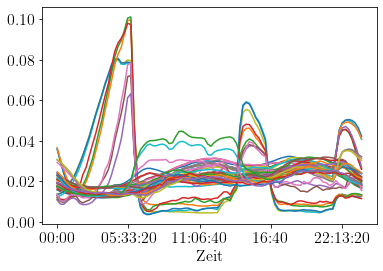

In [8]:
### LASTPROFILE GENERIEREN

load_profiles_list = list()
reg_polynoms_list = list()

for i in range(0,n_clusters):
    load_profiles, coeff_regression = generate_loadprofile(all_powers_list[i],all_powers_list_years[i],plots=False)
    load_profiles_list.insert(len(load_profiles_list), load_profiles)
    reg_polynoms_list.insert(len(reg_polynoms_list), coeff_regression)

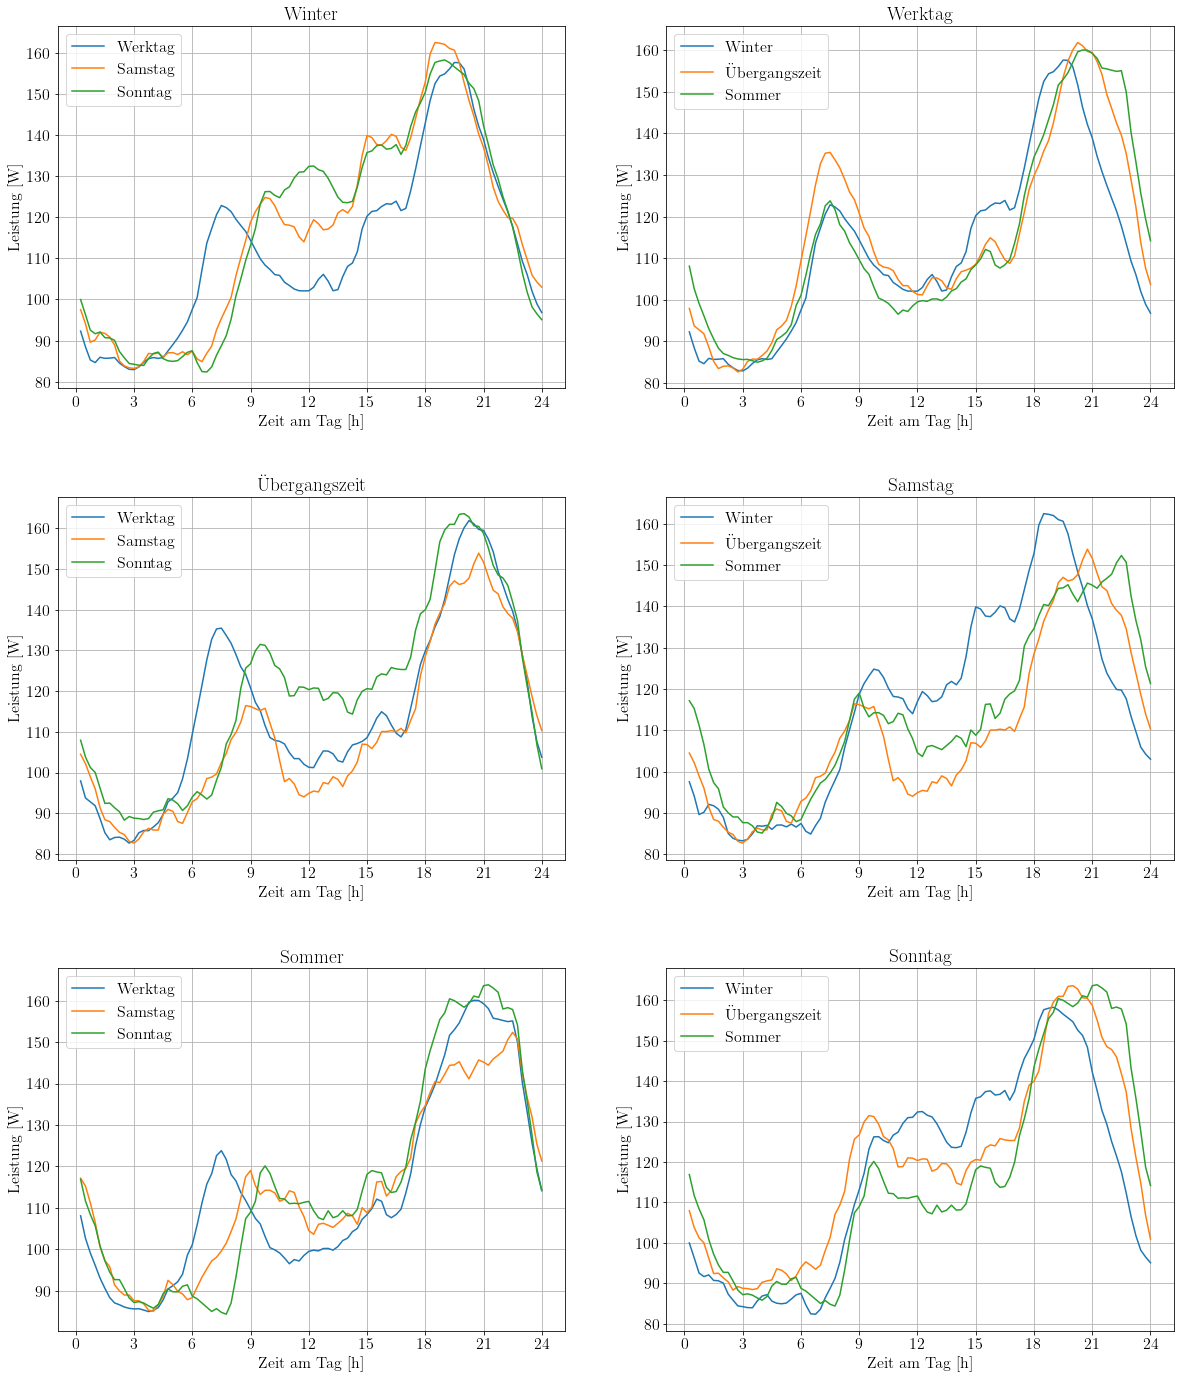

In [9]:
### LASTPROFILE VISUALISIEREN

no=3
profil=load_profiles_list[no]*1000
titel = 'Stationsgruppe' + cluster_names[no]
shorttitle = cluster_names[no]

visualize_typedays(profil, cluster_names[no], export_plots = True, filename='ss_w3')

Analyse

423528.8100639801
(96, 365)
(96, 365)
300633.33865528
(96, 365)
(96, 365)
378593.91545240005
(96, 365)
(96, 365)
907891.1017669201
(96, 365)
(96, 365)
1305378.08193602
(96, 365)
(96, 365)
259094.76618061002
(96, 365)
(96, 365)
103463.30587815
(96, 365)
(96, 365)
1322942.88018966
(96, 365)
(96, 365)
351728.16544285
(96, 365)
(96, 365)


Text(0.5, 0, 'Ortsnetzstation C')

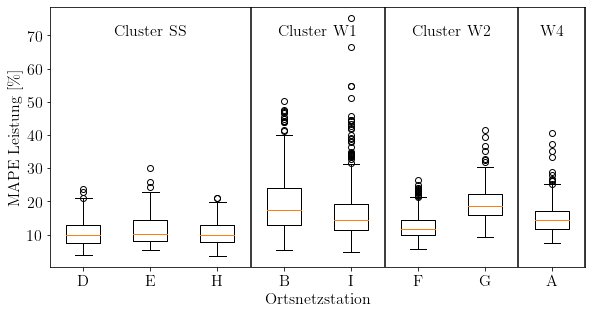

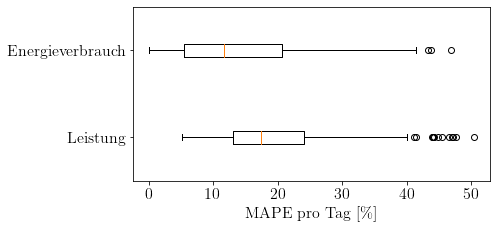

<Figure size 432x288 with 0 Axes>

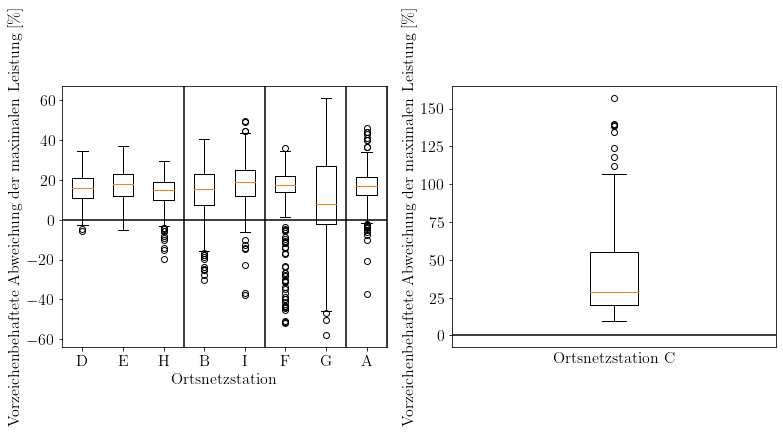

In [10]:
energy_factor=np.array([423528.81006398,  300633.33865528,  378593.9154524 ,907891.10176692, 1305378.08193602,  259094.76618061, 103463.30587815, 1322942.88018966,  351728.16544285])/1000
group = np.array(label)
#group = np.array([4,1,3,0,0,2,2,0,1])
swap = np.array([3,4,7,1,8,5,6,2,0])

res_ges = np.zeros([9,365])
res_ges_energy = np.zeros([9,365])
res_ges_max = np.zeros([9,365])
res_ges_energy_vz = np.zeros([9,365])
res_ges_max_vz = np.zeros([9,365])

for i in range(0,9):
    df_simulation = build_example_year(energy_factor[i]*load_profiles_list[group[i]],reg_polynoms_list[group[i]])
    df_measure = list_power_yd[i][2018]
    res_ges[i], res_ges_max[i], res_ges_energy[i], res_ges_max_vz[i], res_ges_energy_vz[i] = mape_simulation(df_simulation,df_measure)

res_ges_swapped = np.zeros([9,365])
res_ges_swapped_energy = np.zeros([9,365])
res_ges_swapped_max = np.zeros([9,365])
res_ges_swapped_energy_vz = np.zeros([9,365])
res_ges_swapped_max_vz = np.zeros([9,365])
for i in range(0,9):
    res_ges_swapped[i] = res_ges[swap[i]]
    res_ges_swapped_energy[i] = res_ges_energy[swap[i]]
    res_ges_swapped_max[i] = res_ges_max[swap[i]]
    res_ges_swapped_energy_vz[i] = res_ges_energy_vz[swap[i]]
    res_ges_swapped_max_vz[i] = res_ges_max_vz[swap[i]]

#subfig, axs = plt.subplots(1,1,figsize=(19.2,9.6))
#j=0
#i=0
plt.figure(figsize=(9.6,4.8))
plt.boxplot(res_ges_swapped[[0,1,2,3,4,5,6,8]].T)

plt.xticks([1,2,3,4,5,6,7,8],['D','E','H','B','I','F','G','A'])

plt.axvline(x=3.5,color='black')
plt.axvline(x=5.5,color='black')
plt.axvline(x=7.5,color='black')
plt.axvline(x=8.5,color='black')
plt.ylabel('MAPE Leistung [\%]')
plt.xlabel('Ortsnetzstation')
plt.text(2,70,'Cluster SS',horizontalalignment='center')
plt.text(4.5,70,'Cluster W1',horizontalalignment='center')
plt.text(6.5,70,'Cluster W2',horizontalalignment='center')
plt.text(8,70,'W4',horizontalalignment='center')

#plt.savefig('export/Boxplot_MAPE_Leistung_Alle.pdf',bbox_inches='tight')

plt.figure(figsize=(6.4,3.2))
plt.boxplot(np.stack((res_ges_swapped[[3]][0],res_ges_swapped_energy[[3]][0])).T,vert=False)
plt.xlabel('MAPE pro Tag [\%]')
plt.yticks([1,2],['Leistung','Energieverbrauch'])
plt.savefig('export/MAPE_Leistung_Energie_D.pdf',bbox_inches='tight')


"""
subfig, axs = plt.subplots(2,3,figsize=(19.2,9.6))
j=0
i=0
axs[i,j].boxplot(res_ges_swapped[[0,1,2,3,4,5,6,8]].T)
axs[i,j].set_xticks([1,2,3,4,5,6,7,8],['D','E','H','B','I','F','G','A'])

axs[i,j].axvline(x=3.5,color='black')
axs[i,j].axvline(x=5.5,color='black')
axs[i,j].axvline(x=7.5,color='black')
axs[i,j].axvline(x=8.5,color='black')
axs[i,j].set_ylabel('MAPE Leistung [\%]')
axs[i,j].set_xlabel('Ortsnetzstation')

i=1
axs[i,j].boxplot(res_ges_swapped[7].T)
axs[i,j].set_xticks([7],['C'])
axs[i,j].set_ylabel('MAPE Leistung [\%]')
axs[i,j].set_xlabel('Ortsnetzstation C')

j=j+1
i=0
axs[i,j].boxplot(res_ges_swapped_energy[[0,1,2,3,4,5,6,8]].T)
axs[i,j].set_xticks([1,2,3,4,5,6,7,8],['D','E','H','B','I','F','G','A'])
axs[i,j].axvline(x=3.5,color='black')
axs[i,j].axvline(x=5.5,color='black')
axs[i,j].axvline(x=7.5,color='black')
axs[i,j].axvline(x=8.5,color='black')
axs[i,j].set_ylabel('Abweichung tägliche Energie [\%]')
axs[i,j].set_xlabel('Ortsnetzstation')

i=1
axs[i,j].boxplot(res_ges_swapped_energy[7].T)
axs[i,j].set_xticks([7],['C'])
axs[i,j].set_ylabel('Abweichung tägliche Energie [\%]')
axs[i,j].set_xlabel('Ortsnetzstation C')

j=j+1
i=0
axs[i,j].boxplot(res_ges_swapped_max[[0,1,2,3,4,5,6,8]].T)
axs[i,j].set_xticks([1,2,3,4,5,6,7,8],['D','E','H','B','I','F','G','A'])
#plt.boxplot(res_ges_swapped_max.T)
#plt.xticks([1,2,3,4,5,6,7,8,9],['D','E','H','B','I','F','G','C','A'])
axs[i,j].axvline(x=3.5,color='black')
axs[i,j].axvline(x=5.5,color='black')
axs[i,j].axvline(x=7.5,color='black')
axs[i,j].axvline(x=8.5,color='black')
axs[i,j].set_ylabel('Abweichung tägliche maximale Leistung [\%]')
axs[i,j].set_xlabel('Ortsnetzstation')

i=1
axs[i,j].boxplot(res_ges_swapped_max[7].T)
axs[i,j].set_xticks([7],['C'])
axs[i,j].set_ylabel('Abweichung tägliche maximale Leistung [\%]')
axs[i,j].set_xlabel('Ortsnetzstation C')

#plt.savefig('statisch_c_sep.pdf',bbox_inches='tight')
"""
plt.figure()
subfig, axs = plt.subplots(1,2,figsize=(12.8,4.8))
j=0
i=0
des=pd.DataFrame(res_ges_swapped_max_vz[[0,1,2,3,4,5,6,8]].T).describe()
axs[j].boxplot(res_ges_swapped_max_vz[[0,1,2,3,4,5,6,8]].T)
axs[j].set_xticks([1,2,3,4,5,6,7,8],['D','E','H','B','I','F','G','A'])

axs[j].axvline(x=3.5,color='black')
axs[j].axvline(x=5.5,color='black')
axs[j].axvline(x=7.5,color='black')
axs[j].axvline(x=8.5,color='black')
axs[j].axhline(y=0,color='black')
axs[j].set_ylabel('Vorzeichenbehaftete Abweichung der maximalen Leistung [\%]')
axs[j].set_xlabel('Ortsnetzstation')

j=1
axs[j].boxplot(res_ges_swapped[7].T)
axs[j].axhline(y=0,color='black')
axs[j].set_xticks([7],['C'])
axs[j].set_ylabel('Vorzeichenbehaftete Abweichung der maximalen Leistung [\%]')
axs[j].set_xlabel('Ortsnetzstation C')

#plt.savefig('statisch_abs.pdf',bbox_inches='tight')


In [11]:
np.stack((res_ges_swapped_energy[[3]][0],res_ges_swapped_energy[[3]][0]))

array([[11.34990177,  6.08434746, 16.27336833, 20.38823483, 12.59916999,
         4.92136626, 12.78536992, 11.68064942, 23.2833198 , 13.16666733,
         4.37657661, 12.61610108,  2.88436476,  9.96047775, 10.14218753,
        10.88032615, 13.57611287,  6.43798248,  4.78793985,  3.66625484,
         3.19166831,  1.47895826,  3.99450488, 16.90739416, 19.72132123,
        20.67443135, 24.21251638, 18.9113753 , 13.24034293,  6.52582561,
         2.97957201,  8.38261655,  3.91451838,  3.43001073,  9.64815443,
         8.45071774, 14.96072024, 17.66612932, 19.84622408, 13.10468855,
         8.68839603,  7.17404258,  7.88389401,  5.70080653,  3.57386873,
         2.16229537,  5.4938279 , 11.24251029,  7.68663646, 11.79468236,
        24.09382072, 30.36142614, 30.33264022, 27.51221401, 25.0059469 ,
        27.56250691, 32.25007747, 32.60972974, 39.58877641, 36.61465477,
        43.68116033, 46.79501516, 34.74639596, 28.64249031, 28.43576078,
        33.2207479 , 36.39288211, 32.70697099, 13.4

907891.1017669201


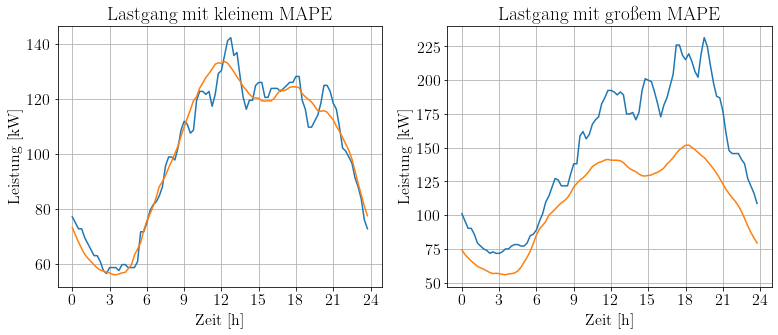

In [12]:
i=3

minimal=np.argmin(res_ges[i])
maximal=np.argmax(res_ges[i])
minimal_MAPE=np.min(res_ges[i])
maximal_MAPE=np.max(res_ges[i])
df_simulation = build_example_year(energy_factor[i]*load_profiles_list[group[i]],reg_polynoms_list[group[i]])
wide_simulation = np.reshape(df_simulation,[96,365],order='F')

YminMess = list_power_yd[i][2018].iloc[:,minimal].to_numpy()
YminSim = wide_simulation[:,minimal]

YmaxMess = list_power_yd[i][2018].iloc[:,maximal].to_numpy()
YmaxSim = wide_simulation[:,maximal]

subfig, axs = plt.subplots(1,2,figsize=(12.8,4.8))
axs[0].plot(YminMess)
axs[0].plot(YminSim)
axs[0].set_title('Lastgang mit kleinem MAPE')
axs[0].set_xlabel('Zeit [h]')
axs[0].set_xticks(np.arange(0,108, step=12),np.arange(0,25, step=3))
axs[0].set_ylabel('Leistung [kW]')
axs[0].grid()

axs[1].plot(YmaxMess)
axs[1].plot(YmaxSim)
axs[1].set_title('Lastgang mit großem MAPE')
axs[1].set_xlabel('Zeit [h]')
axs[1].set_xticks(np.arange(0,108, step=12),np.arange(0,25, step=3))
axs[1].set_ylabel('Leistung [kW]')
axs[1].grid()
plt.savefig('statisch_vgl_tag.pdf',bbox_inches='tight')

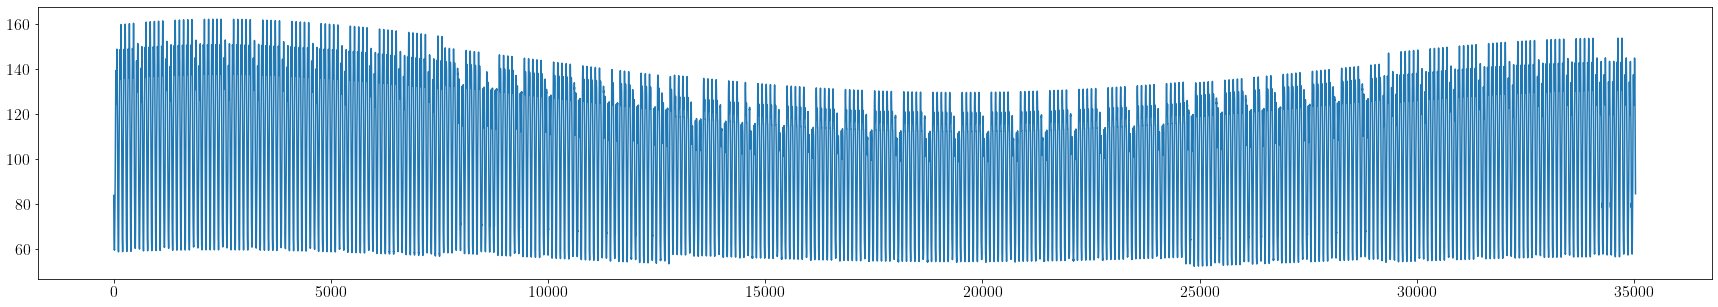

In [15]:
plt.figure(figsize=(30,5))
plt.plot(df_simulation)

In [16]:
pd.DataFrame(df_simulation).to_csv('Statisch')

Variation

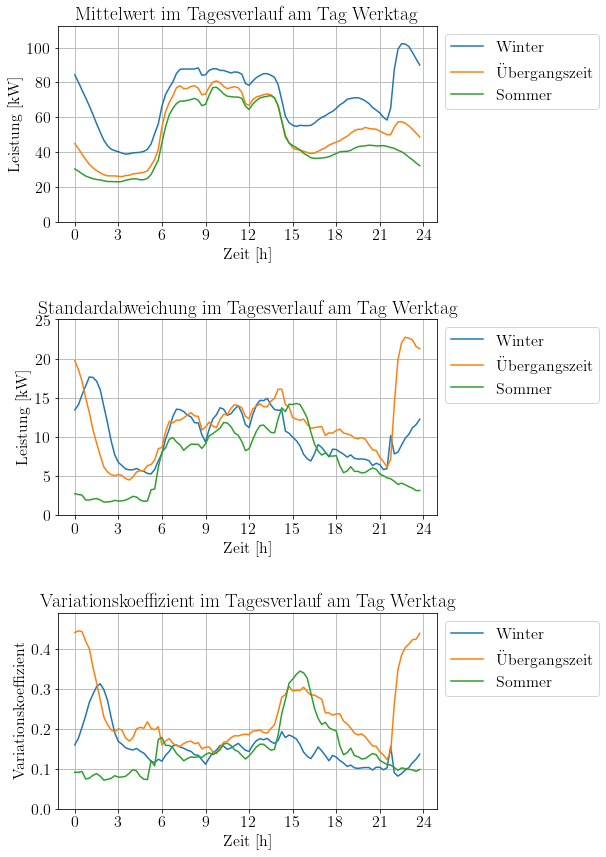

In [13]:
vk_list=list()
for i in range(0,1):
    vk_list.insert(len(vk_list),dp.stochastic_analysis(list_power_ysd[i][2018],varianzkoeff=True))
    plt.savefig('export/stoch_ana_s' + 'i' + '.pdf',bbox_inches='tight')